In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras


In [2]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    asicVersion = 3
)
root.start()

Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 0:05:45
GitHash      = 0xb4065f9cb3d8e66c14854127342c437998d5e992
XilinxDnaId  = 0x40020001013a928124b102c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv304 (Ubuntu 20.04.5 LTS)
BuildDate    = Fri 09 Sep 2022 11:26:03 AM PDT
Builder      = ddoering
###################################################


In [4]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
root.EpixHR.InitASIC([2,0,1,0,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic1

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_RegisterControl_150us_320MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 2
Disabling packet lanes for ASIC 3
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_1.yml
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.Ep

In [15]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [16]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3F)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)

Locked lanes: fc0


In [17]:
def readPixelConfig(ASIC, x, y):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.get() #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

def writedPixelConfig(ASIC, x, y, value):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.set(value) #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

In [18]:
print(ASIC.CompTH_DAC.get())
print(ASIC.CompEn.get())
print(ASIC.CompEnOn.get())
print(ASIC.Filter_DAC.get())

42
7
False
38


In [9]:
#sets ASIC to point to the external DAC
ASIC.mTest.set(False)
ASIC.trbit.set(False)
ASIC.CompTH_DAC.set(42)
ASIC.CompEnOn.set(False)
ASIC.test.set(True)
ASIC.atest.set(True)
print (f'Check trbit (0: medium gain, 1: high gain): %d' % ASIC.trbit.get())
#set pixel configuration
pixelList = [[20, 30, 1],[20, 35, 5],[20, 40, 9],[20, 45, 13]]
pixelOffset = 192
pixelListRB = [[20, 30+pixelOffset, 1],[20, 35+pixelOffset, 5],[20, 40+pixelOffset, 9],[20, 45+pixelOffset, 13]]
for i in range(len(pixelList)):
    print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    print (f'Writing individula pixel')
    writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pixelList[i][2])
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))

for i in range(192):    
    writedPixelConfig(ASIC, 25, i, 1)
    
#code to check successive writes
#row = 111
#col = 180
#for pixelValue in (0, 8, 4, 12):
#    writedPixelConfig(ASIC, row, col, pixelValue)
#    print (f'Pixel setting %d (0: AR, 4: forced switch, 8: fixed low, 12: fixed high), readback: %d' % (pixelValue, readPixelConfig(ASIC, row, col)))


Check trbit (0: medium gain, 1: high gain): 0

Pixel [20, 30]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [20, 35]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 7

Pixel [20, 40]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9

Pixel [20, 45]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13


In [28]:
# Remove previous dataset
#if os.path.isfile(f'{top_level}/test.dat'):
#    os.remove(f'{top_level}/test.dat')    
filename = '/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_atest_320MHz_AML_run1.dat'

In [49]:
if os.path.isfile(f'{filename}'):
    os.remove(f'{filename}')    
    
# Setup and open the file writer
writer = root.dataWriter._writer
writer.open(f'{filename}')

# Wait for the file write to open the file
while( writer.isOpen() is False):
    time.sleep(0.1)

# Wait a little bit for the file to open up
time.sleep(1.0)    
    
#sets TriggerRegisters
AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
print("Aquisition Counter " + str(AcqCount))
root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(50000) #in steps of 10ns
root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
#wait for the camera to get thermally stable
time.sleep(5.0)    
root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
initialFrameCounter = writer.getFrameCount()
# Wait for the file write noise data
while(writer.getFrameCount() < initialFrameCounter + 3000):
    print( f'Number of frames received: {writer.getFrameCount()}' )
    time.sleep(1)

# stops triggers
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

# Print the status
DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
#print( f'Delta Aquisition Counter: {DeltaAcqCount}')
print( f'Number of frames received: {writer.getFrameCount()}' )
        
# Close the file writer
writer.close()

# Wait for the file write to close the file
while( writer.isOpen() is True):
    time.sleep(0.1)

Aquisition Counter 275020
Number of frames received: 10010
Number of frames received: 12013
Number of frames received: 14016


In [30]:
from importlib import reload
reload(cameras)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask
currentCam.MAX_NUMBER_OF_FRAMES_PER_BATCH  = MAX_NUMBER_OF_FRAMES_PER_BATCH


Camera  ePixHr10kTBatcher  selected.


In [57]:
f = open(filename, mode = 'rb')
imgDesc = []
for i in range(2):
    print("Starting to get data set %d" % (i))
    allFrames = currentCam.getData(f,4)
    imgDesc2 = currentCam.getDescImaData(allFrames)
    if i == 0:
        headers = allFrames[:,0:6]
        imgDesc = imgDesc2   
    else:
        headers = np.concatenate((headers, allFrames[:,0:6]),0)
        imgDesc = np.concatenate((imgDesc, imgDesc2),0)
    if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
        break


numberOfFrames = allFrames.shape[0]
print(allFrames.shape)

Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56092)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


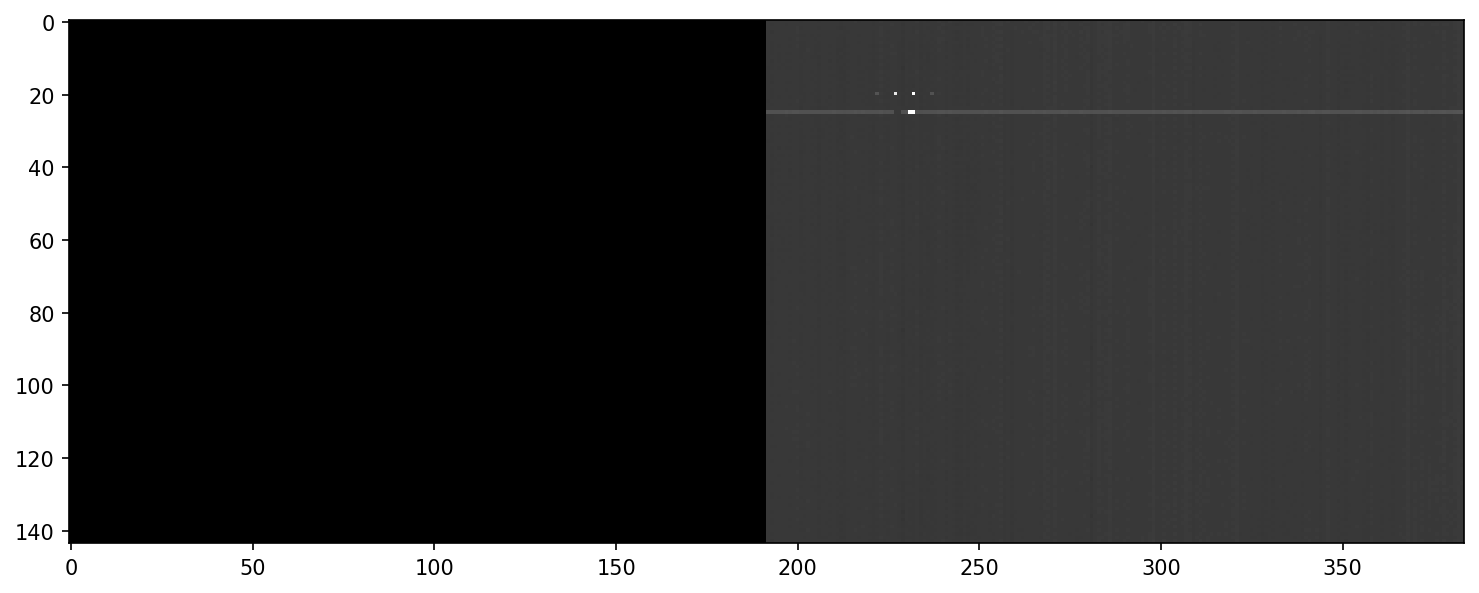

In [58]:
plt.figure(1,figsize=(12,8),dpi=150)
plt.imshow(imgDesc[100], cmap='gray')
print(imgDesc[100,100,20:40])

(144, 384)


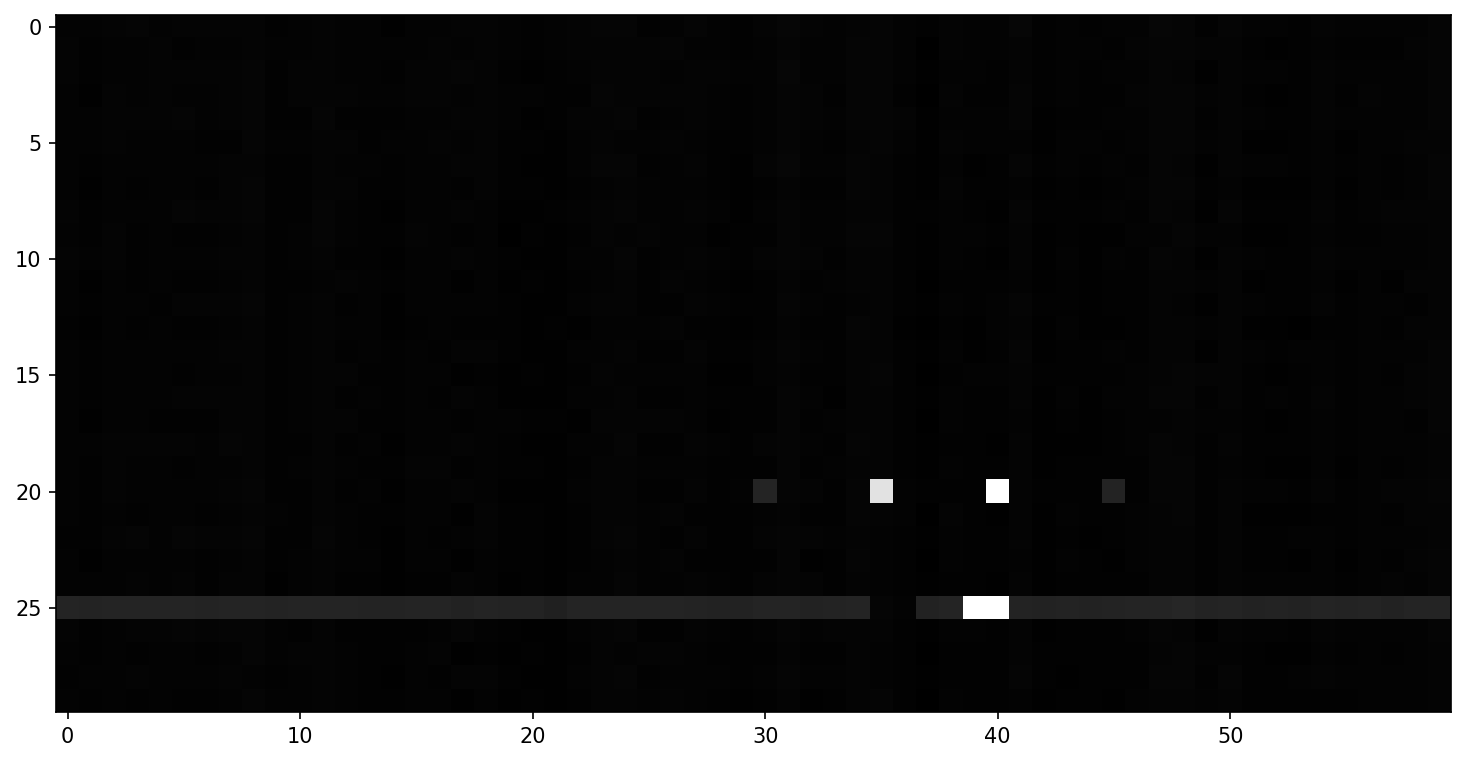

In [59]:
print(imgDesc[100].shape)
plt.figure(1,figsize=(12,8),dpi=150)
plt.imshow(imgDesc[100,0:30,192:252], cmap='gray')


0
(2000, 144, 384)
20 222
1
(2000, 144, 384)
20 227
2
(2000, 144, 384)
20 232
3
(2000, 144, 384)
20 237


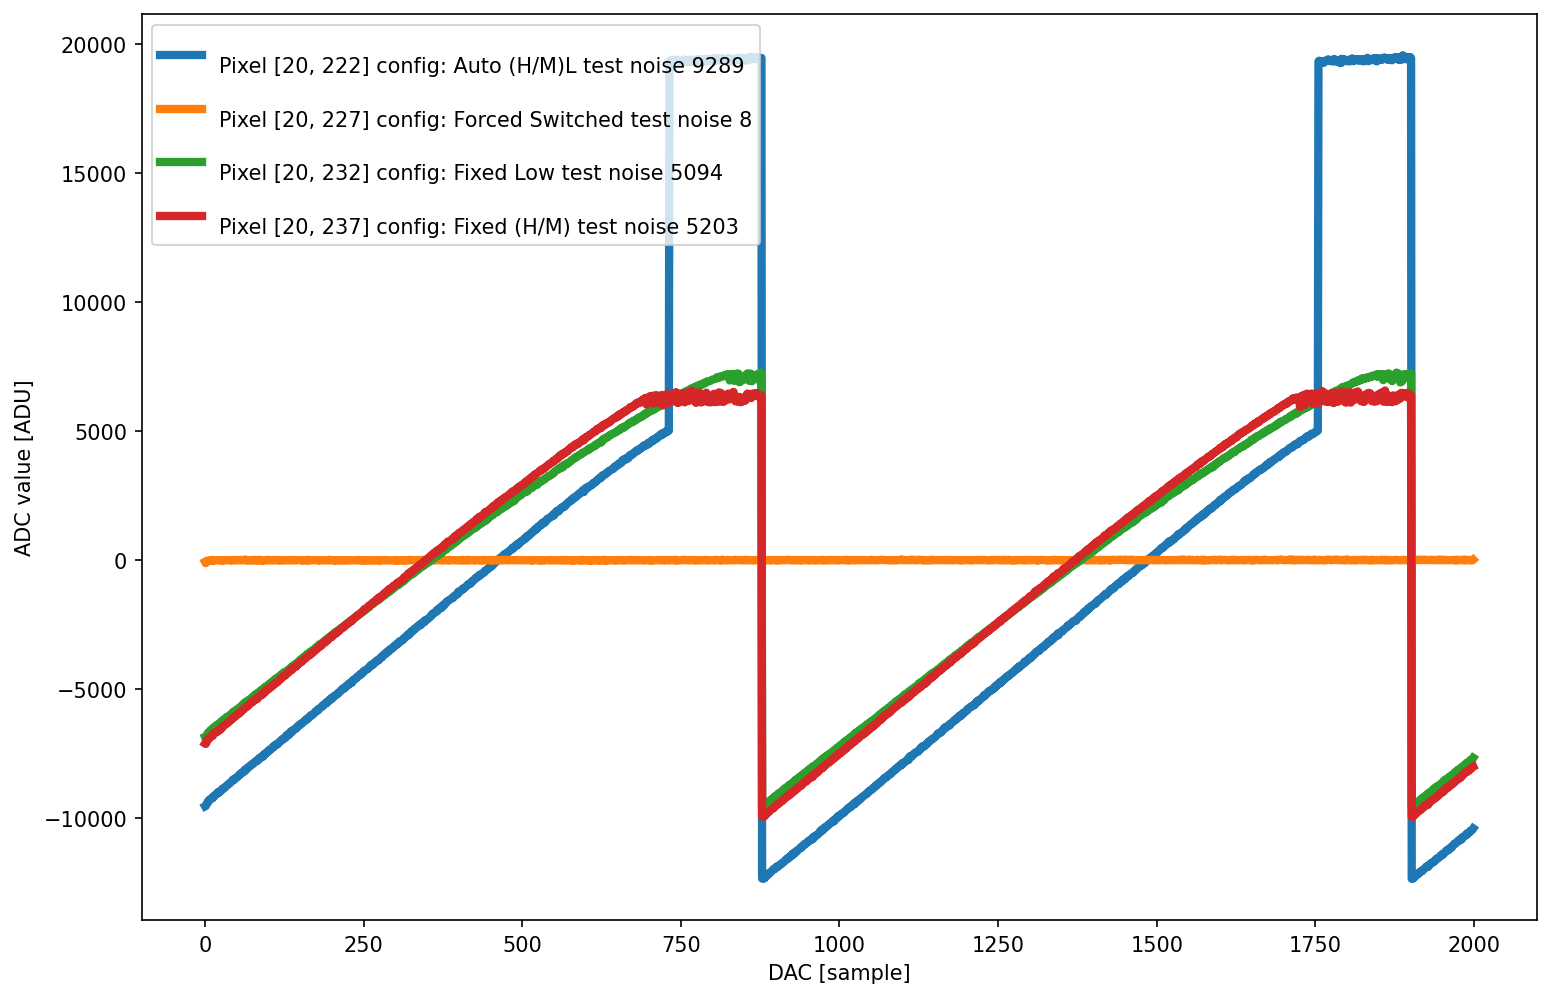

In [60]:
pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
revd=dict([reversed(i) for i in pixelSettings.items()])
pixelSettings.update(revd)

plt.figure(1,figsize=(12,8),dpi=150)
for i in range(len(pixelListRB)):
    print(i)
    print(imgDesc.shape)
    print(pixelListRB[i][0],pixelListRB[i][1])
    dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
    plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]], np.std(dataset)))
plt.xlabel('DAC [sample]')
plt.ylabel('ADC value [ADU]')
plt.legend()
plt.show()

0
(2000, 144, 384)
25 222
1
(2000, 144, 384)
25 227
2
(2000, 144, 384)
25 232
3
(2000, 144, 384)
25 237


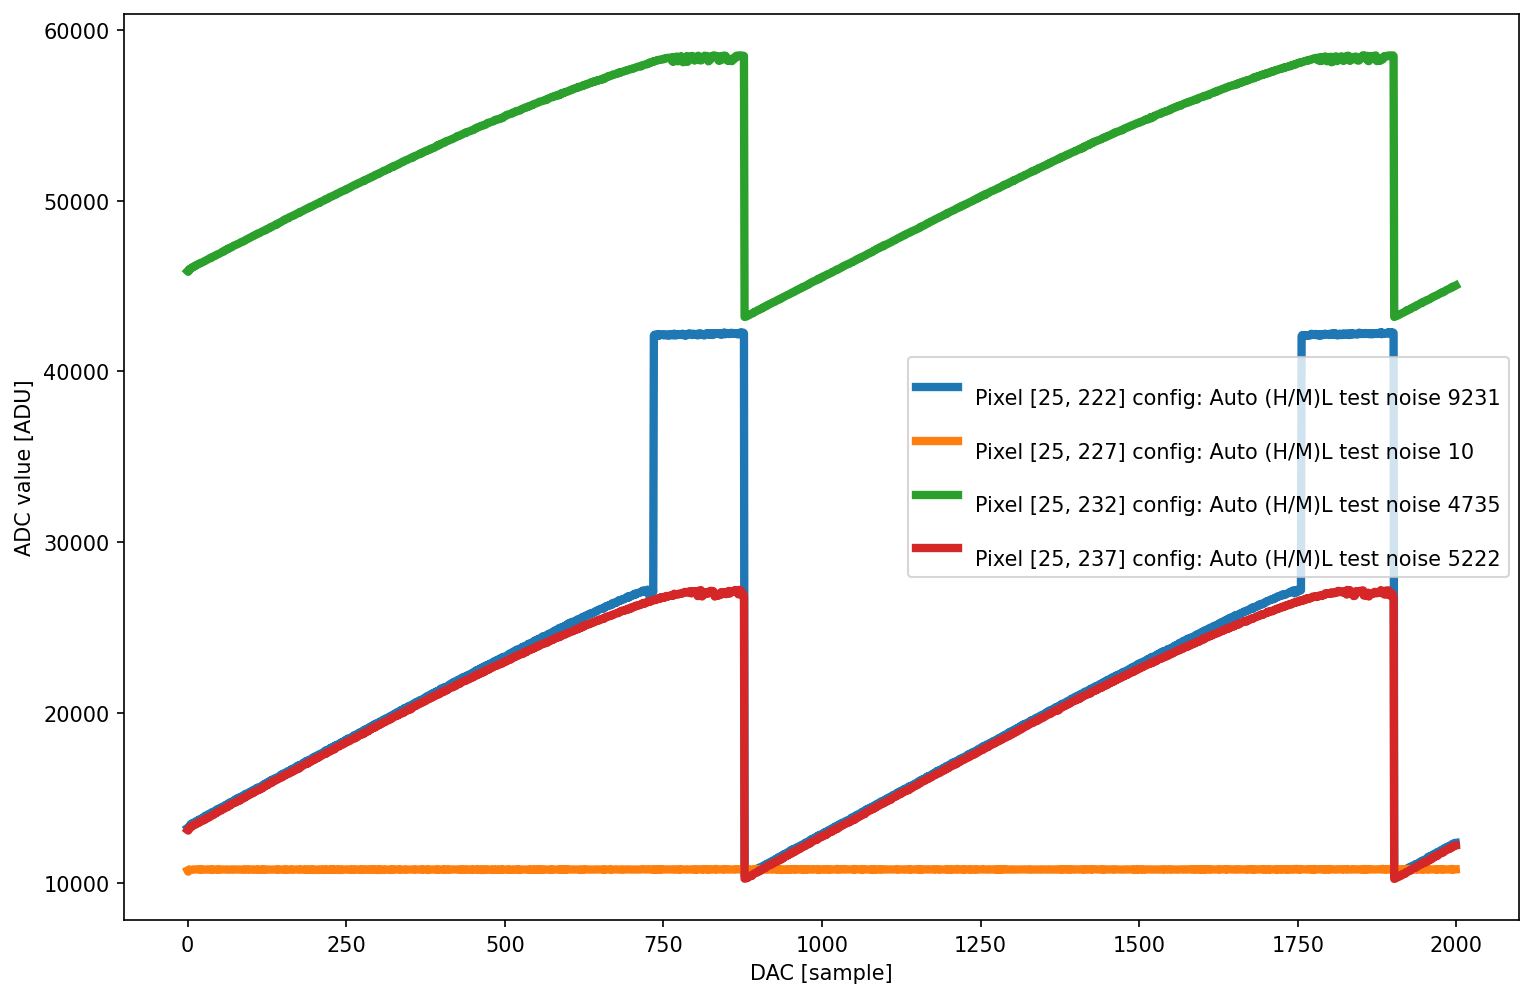

In [61]:
pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
revd=dict([reversed(i) for i in pixelSettings.items()])
pixelSettings.update(revd)

plt.figure(1,figsize=(12,8),dpi=150)
for i in range(len(pixelListRB)):
    print(i)
    print(imgDesc.shape)
    print(25,pixelListRB[i][1])
    dataset = imgDesc[:,25,pixelListRB[i][1]] 
    plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (25, pixelListRB[i][1], pixelSettings[pixelList[0][2]], np.std(dataset)))
plt.xlabel('DAC [sample]')
plt.ylabel('ADC value [ADU]')
plt.legend()
plt.show()

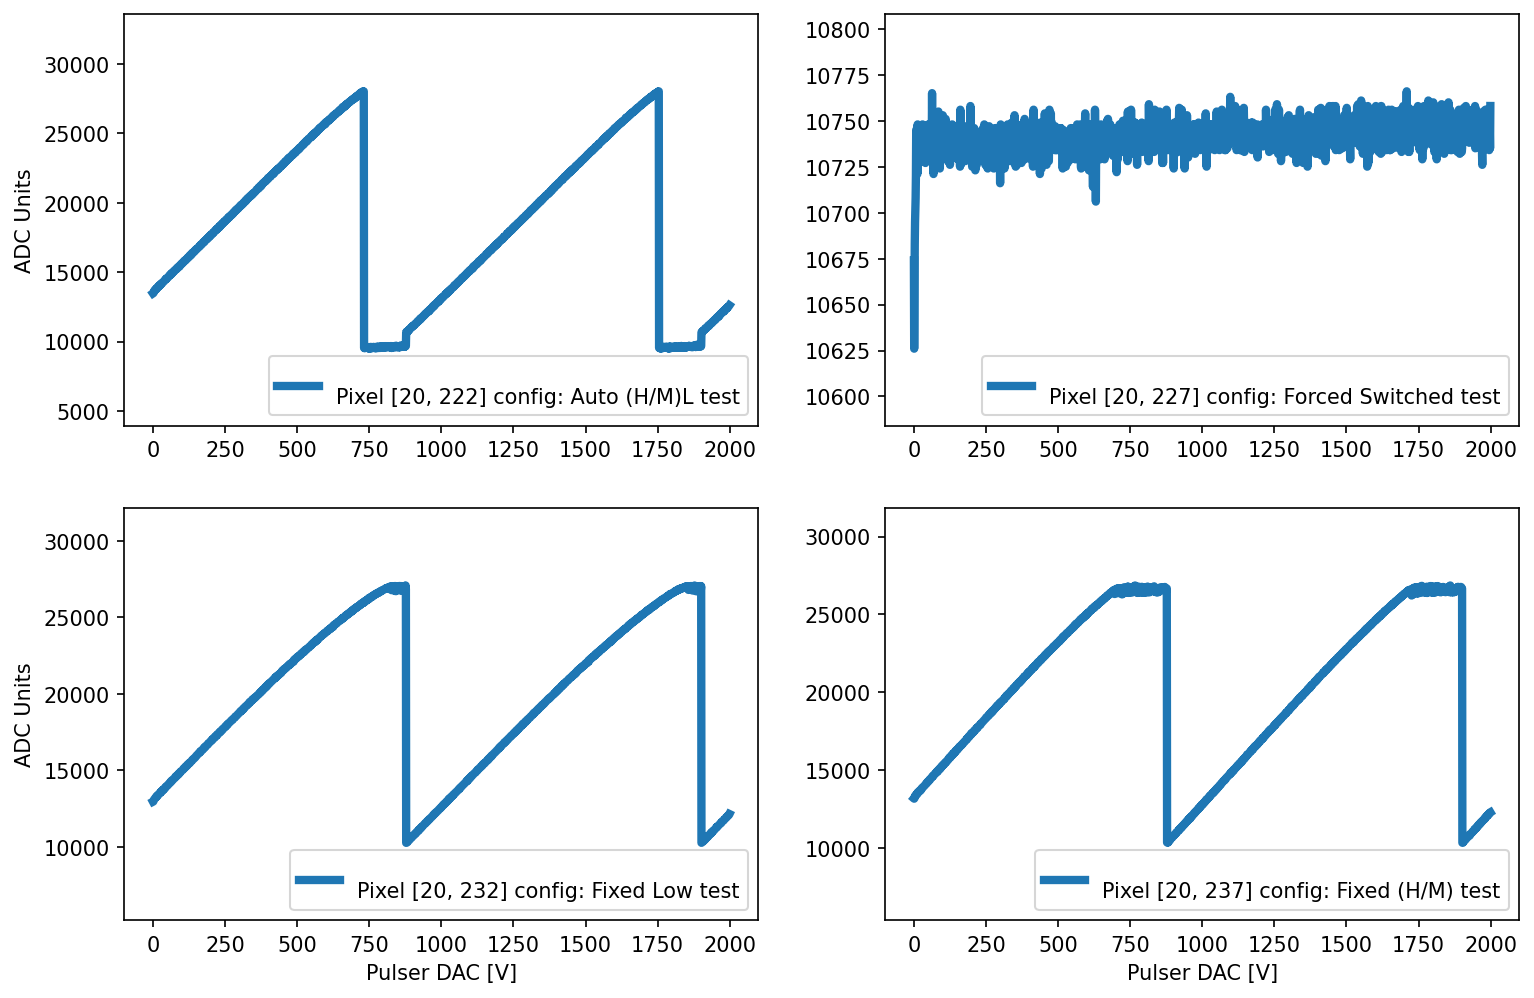

In [63]:
fig, axs = plt.subplots(2, 2,figsize=(12,8),dpi=150)
startingColumn = 30
for i in range(len(pixelListRB)):
    dataset = imgDesc[5:,pixelListRB[i][0],pixelListRB[i][1]] & 0x7fff
    axs[int(i/2),i%2].plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]]))
    axs[int(i/2),i%2].legend(loc=4)
    axs[int(i/2),i%2].margins(0.05, 0.3)
    
axs[1,0].set_xlabel('Pulser DAC [V]')
axs[1,1].set_xlabel('Pulser DAC [V]')
axs[0,0].set_ylabel('ADC Units')
axs[1,0].set_ylabel('ADC Units')

plt.show()

In [ ]:
for i in range(len(pixelListRB)):
    print(i)
    print(imgDesc.shape)
    print(pixelListRB[i][0],pixelListRB[i][1])
    print(imgDesc[:20,pixelListRB[i][0],pixelListRB[i][1]])

In [ ]:
plt.figure(1,figsize=(12,8),dpi=150)
for i in range(len(pixelListRB)):
    dataset = (imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]])# - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
    plt.hist(dataset.reshape(-1), bins=100, label=f'\nPixel [%d, %d] config: %s noise %d' %(pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelListRB[i][2]], np.std(dataset))) 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()